In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import PolynomialFeatures, StandardScaler as SkStandardScaler, MinMaxScaler as SkMinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression as SkLinearRegression, Ridge as SkRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, KFold

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid")

TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"


In [67]:

def perform_detailed_eda(df_orig):
    """
    Функция строит графики для анализа данных перед обучением.
    """
    print("\n" + "="*50)
    print("                         EDA             ")
    print("="*50)
    
    df = df_orig.copy()
    
    cols_to_drop = ['ID', 'Id']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        min_date = pd.Timestamp("1970-01-01")
        df['AppDays'] = (df['ApplicationDate'] - min_date).dt.days
        df = df.drop(columns=['ApplicationDate'])

    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    plt.figure(figsize=(10, 5))
    sns.histplot(df['RiskScore'], kde=True, bins=40, color='teal')
    plt.title('Распределение RiskScore')
    plt.xlabel('RiskScore')
    plt.show()

    print(" Строим матрицу корреляций")
    plt.figure(figsize=(14, 12))
    corr = df[num_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool)) 
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".2f", annot_kws={"size": 7})
    plt.title('Матрица корреляций признаков')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    if 'RiskScore' in corr.columns:
        target_corr = corr['RiskScore'].drop('RiskScore').sort_values(ascending=False)
        plt.figure(figsize=(10, 8))
        colors = ['#d62728' if x > 0 else '#1f77b4' for x in target_corr.values]
        sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)
        plt.axvline(0, color='black', linewidth=1)
        plt.title('Корреляция признаков с RiskScore (Пирсон)')
        plt.xlabel('Коэффициент корреляции')
        plt.show()


    if 'RiskScore' in corr.columns:
        top_features = corr['RiskScore'].abs().sort_values(ascending=False).index[1:10]
        
        n_cols = 3
        n_rows = (len(top_features) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
        axes = axes.flatten()
        
        for i, col in enumerate(top_features):
            sample_df = df.sample(min(len(df), 2000), random_state=42)
            sns.regplot(data=sample_df, x=col, y='RiskScore', ax=axes[i], 
                        scatter_kws={'alpha': 0.2, 's': 10}, line_kws={'color': 'red'})
            axes[i].set_title(f'{col} vs RiskScore')
            
        for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()


    if len(cat_cols) > 0:
        n_rows_cat = (len(cat_cols) + 3 - 1) // 3
        fig, axes = plt.subplots(n_rows_cat, 3, figsize=(18, 5 * n_rows_cat))
        if n_rows_cat == 1 and len(cat_cols) <= 3: axes = np.array(axes).flatten()
        else: axes = axes.flatten()
        
        for i, col in enumerate(cat_cols):
            order = df.groupby(col)['RiskScore'].median().sort_values().index
            sns.boxplot(data=df, x=col, y='RiskScore', ax=axes[i], order=order, palette='viridis')
            axes[i].set_title(f'{col} vs RiskScore')
            axes[i].tick_params(axis='x', rotation=45)
            
        for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()


In [68]:

class MyStandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1.0
        return self
    def transform(self, X):
        return (X - self.mean) / self.std
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class MyMinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None
    def fit(self, X):
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)
        return self
    def transform(self, X):
        denom = self.max - self.min
        denom[denom == 0] = 1.0
        return (X - self.min) / denom
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class MyLinearRegression:
    def __init__(self, method='analytical', lr=0.001, epochs=1000, batch_size=32, alpha=0.0):
        self.method = method 
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.alpha = alpha
        self.weights = None
        
    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        n_samples, n_features = X.shape
        
        if self.method == 'analytical':
            I = np.eye(n_features)
            I[0, 0] = 0 
            XtX = X.T.dot(X) + self.alpha * I
            try:
                self.weights = np.linalg.solve(XtX, X.T.dot(y))
            except np.linalg.LinAlgError:
                self.weights = np.linalg.pinv(XtX).dot(X.T.dot(y))
                
        elif self.method == 'gd':
            self.weights = np.zeros(n_features)
            for _ in range(self.epochs):
                y_pred = X.dot(self.weights)
                grad = (2/n_samples) * X.T.dot(y_pred - y) + 2 * self.alpha * self.weights
                grad[0] -= 2 * self.alpha * self.weights[0]
                self.weights -= self.lr * grad
                
        elif self.method == 'sgd':
            self.weights = np.zeros(n_features)
            for _ in range(self.epochs):
                indices = np.random.permutation(n_samples)
                X_sh = X[indices]
                y_sh = y[indices]
                for i in range(0, n_samples, self.batch_size):
                    Xi = X_sh[i:i+self.batch_size]
                    yi = y_sh[i:i+self.batch_size]
                    y_p = Xi.dot(self.weights)
                    grad = (2/Xi.shape[0]) * Xi.T.dot(y_p - yi) + 2 * self.alpha * self.weights
                    grad[0] -= 2 * self.alpha * self.weights[0]
                    self.weights -= self.lr * grad

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X.dot(self.weights)

In [69]:

def my_mse(y_true, y_pred): return np.mean((y_true - y_pred)**2)
def my_mae(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))
def my_r2(y_true, y_pred): 
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
def my_mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10)))

def my_kfold_cv(model_cls, X, y, k=5, **kwargs):
    n = len(X)
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_size = n // k
    scores = []
    for i in range(k):
        test_idx = indices[i*fold_size : (i+1)*fold_size]
        train_idx = np.setdiff1d(indices, test_idx)
        model = model_cls(**kwargs)
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[test_idx])
        scores.append(my_mse(y[test_idx], preds))
    return np.mean(scores)


def norm_feat(s):
    return (s - s.min()) / (s.max() - s.min())

def create_time_features(df):
    df = df.copy()
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        df['ApplicationDate'] = df['ApplicationDate'].fillna(df['ApplicationDate'].mode()[0])
        min_date = pd.Timestamp("1970-01-01")
        df["AppDays"] = (df["ApplicationDate"] - min_date).dt.days
        df["AppYear"] = df["ApplicationDate"].dt.year
        df["AppMonth"] = df["ApplicationDate"].dt.month
        df = df.drop(columns=['ApplicationDate'])
    return df

def create_geometry_features(df):
    df = df.copy()
    sc = df['CreditScore'].fillna(df['CreditScore'].median())
    inc = df['AnnualIncome'].fillna(df['AnnualIncome'].median())
    dti = df['DebtToIncomeRatio'].fillna(df['DebtToIncomeRatio'].median())
    sc_n, inc_n, dti_n = norm_feat(sc), norm_feat(inc), norm_feat(dti)
    df['Dist_to_Bad'] = np.sqrt(sc_n**2 + inc_n**2 + (1 - dti_n)**2)
    df['Dist_to_Good'] = np.sqrt((1 - sc_n)**2 + (1 - inc_n)**2 + dti_n**2)
    return df

In [70]:


def create_base_features(df):
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols: df[col] = df[col].fillna(df[col].median())
        
    log_cols = ["AnnualIncome", "TotalAssets", "TotalLiabilities", "NetWorth", "LoanAmount"]
    for col in log_cols:
        if col in df.columns:
            min_val = df[col].min()
            shift = abs(min_val) + 1.0 if min_val < 0 else 1.0
            df[f'Log_{col}'] = np.log(df[col] + shift)

    if 'AnnualIncome' in df.columns and 'NumberOfDependents' in df.columns:
        df['Income_per_person'] = df['AnnualIncome'] / (df['NumberOfDependents'] + 1)
    if 'InterestRate' in df.columns and 'BaseInterestRate' in df.columns:
        df['Interest_Spread'] = df['InterestRate'] - df['BaseInterestRate']

    if 'CreditScore' in df.columns:
        df['CreditScore_Bin'] = pd.qcut(df['CreditScore'], q=10, labels=False, duplicates='drop')
    if 'AnnualIncome' in df.columns:
        df['Income_Bin'] = pd.qcut(df['AnnualIncome'], q=5, labels=False, duplicates='drop')
    if 'LoanAmount' in df.columns:
        df['LoanAmount_Bin'] = pd.qcut(df['LoanAmount'], q=10, labels=False, duplicates='drop')
    if 'DebtToIncomeRatio' in df.columns:
        df['DTI_Bin'] = pd.qcut(df['DebtToIncomeRatio'], q=10, labels=False, duplicates='drop')
        
    return df

def process_and_encode_main(train_orig, test_orig):
    train = train_orig.copy()
    test = test_orig.copy()
    
    y_train = train['RiskScore']
    low = y_train.quantile(0.012)
    high = y_train.quantile(0.991)
    train = train[(train['RiskScore'] >= low) & (train['RiskScore'] <= high)].reset_index(drop=True)
    y_train = train['RiskScore']
    train = train.drop('RiskScore', axis=1)
    
    train['is_train'] = 1
    test['is_train'] = 0
    full = pd.concat([train, test], axis=0).reset_index(drop=True)
    full = full.drop(columns=['ID', 'Id'], errors='ignore')
    
    full = create_time_features(full)
    full = create_base_features(full)
    full = create_geometry_features(full)
    
    te_cols = ["EducationLevel", "EmploymentStatus", "HomeOwnershipStatus", "LoanPurpose", 
               "Income_Bin", "CreditScore_Bin", "LoanAmount_Bin", "DTI_Bin"]
    te_cols = [c for c in te_cols if c in full.columns]
    
    df_train = full[full['is_train'] == 1].copy()
    df_test = full[full['is_train'] == 0].copy()
    df_train['RiskScore'] = y_train.values
    global_median = df_train['RiskScore'].median()
    
    for col in te_cols:
        mapper = df_train.groupby(col)['RiskScore'].median()
        full.loc[full['is_train'] == 1, f'{col}_TE'] = df_train[col].map(mapper)
        full.loc[full['is_train'] == 0, f'{col}_TE'] = df_test[col].map(mapper)
        full[f'{col}_TE'] = full[f'{col}_TE'].fillna(global_median)
        
    full = full.select_dtypes(include=[np.number])
    X_train = full[full['is_train'] == 1].drop('is_train', axis=1).values
    X_test = full[full['is_train'] == 0].drop('is_train', axis=1).values
    
    selector = VarianceThreshold(threshold=0)
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    
    correlations = []
    for i in range(X_train.shape[1]):
        c = np.corrcoef(X_train[:, i], y_train)[0, 1]
        correlations.append(abs(c) if not np.isnan(c) else 0)
        
    top_30_idx = np.argsort(correlations)[-30:]
    poly2 = PolynomialFeatures(degree=2, include_bias=False)
    X_tr_p2 = poly2.fit_transform(X_train[:, top_30_idx])[:, 30:]
    X_te_p2 = poly2.transform(X_test[:, top_30_idx])[:, 30:]
    
    top_5_idx = np.argsort(correlations)[-5:]
    poly3 = PolynomialFeatures(degree=3, include_bias=False)
    X_tr_p3 = poly3.fit_transform(X_train[:, top_5_idx])[:, 5:]
    X_te_p3 = poly3.transform(X_test[:, top_5_idx])[:, 5:]
    
    X_train_final = np.hstack([X_train, X_tr_p2, X_tr_p3])
    X_test_final = np.hstack([X_test, X_te_p2, X_te_p3])
    
    return X_train_final, y_train.values, X_test_final


                         EDA             


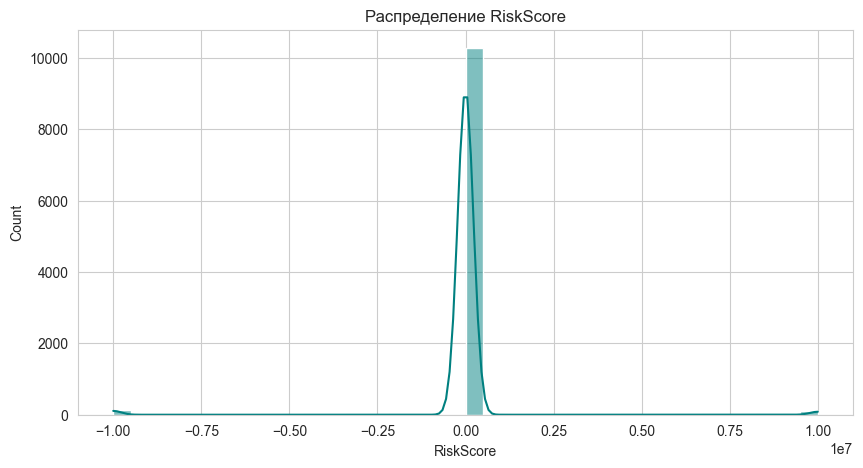

 Строим матрицу корреляций


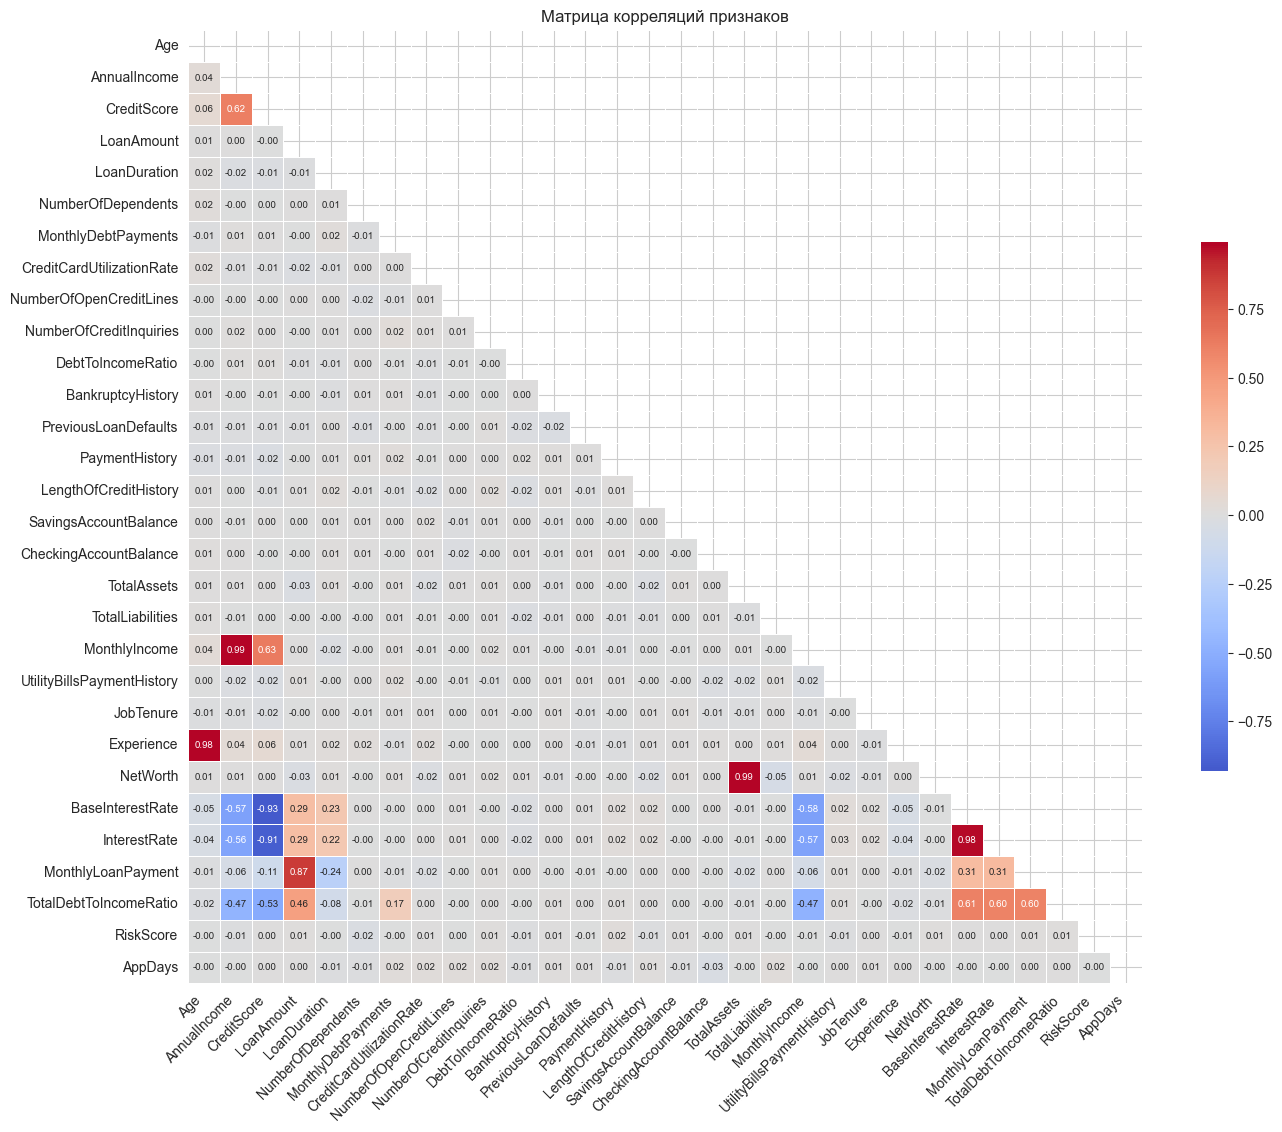

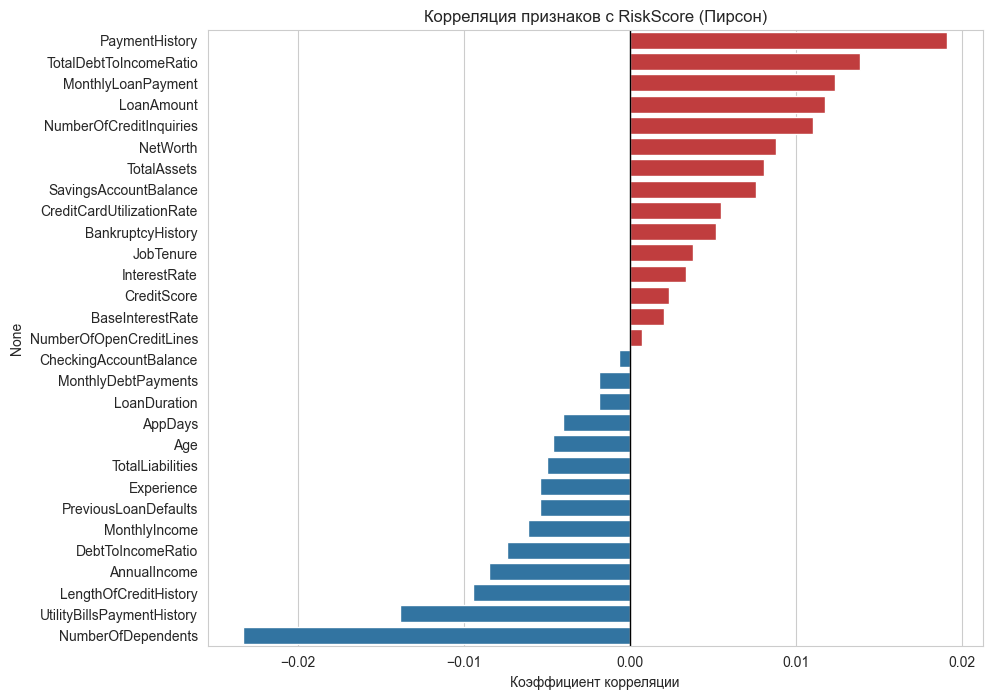

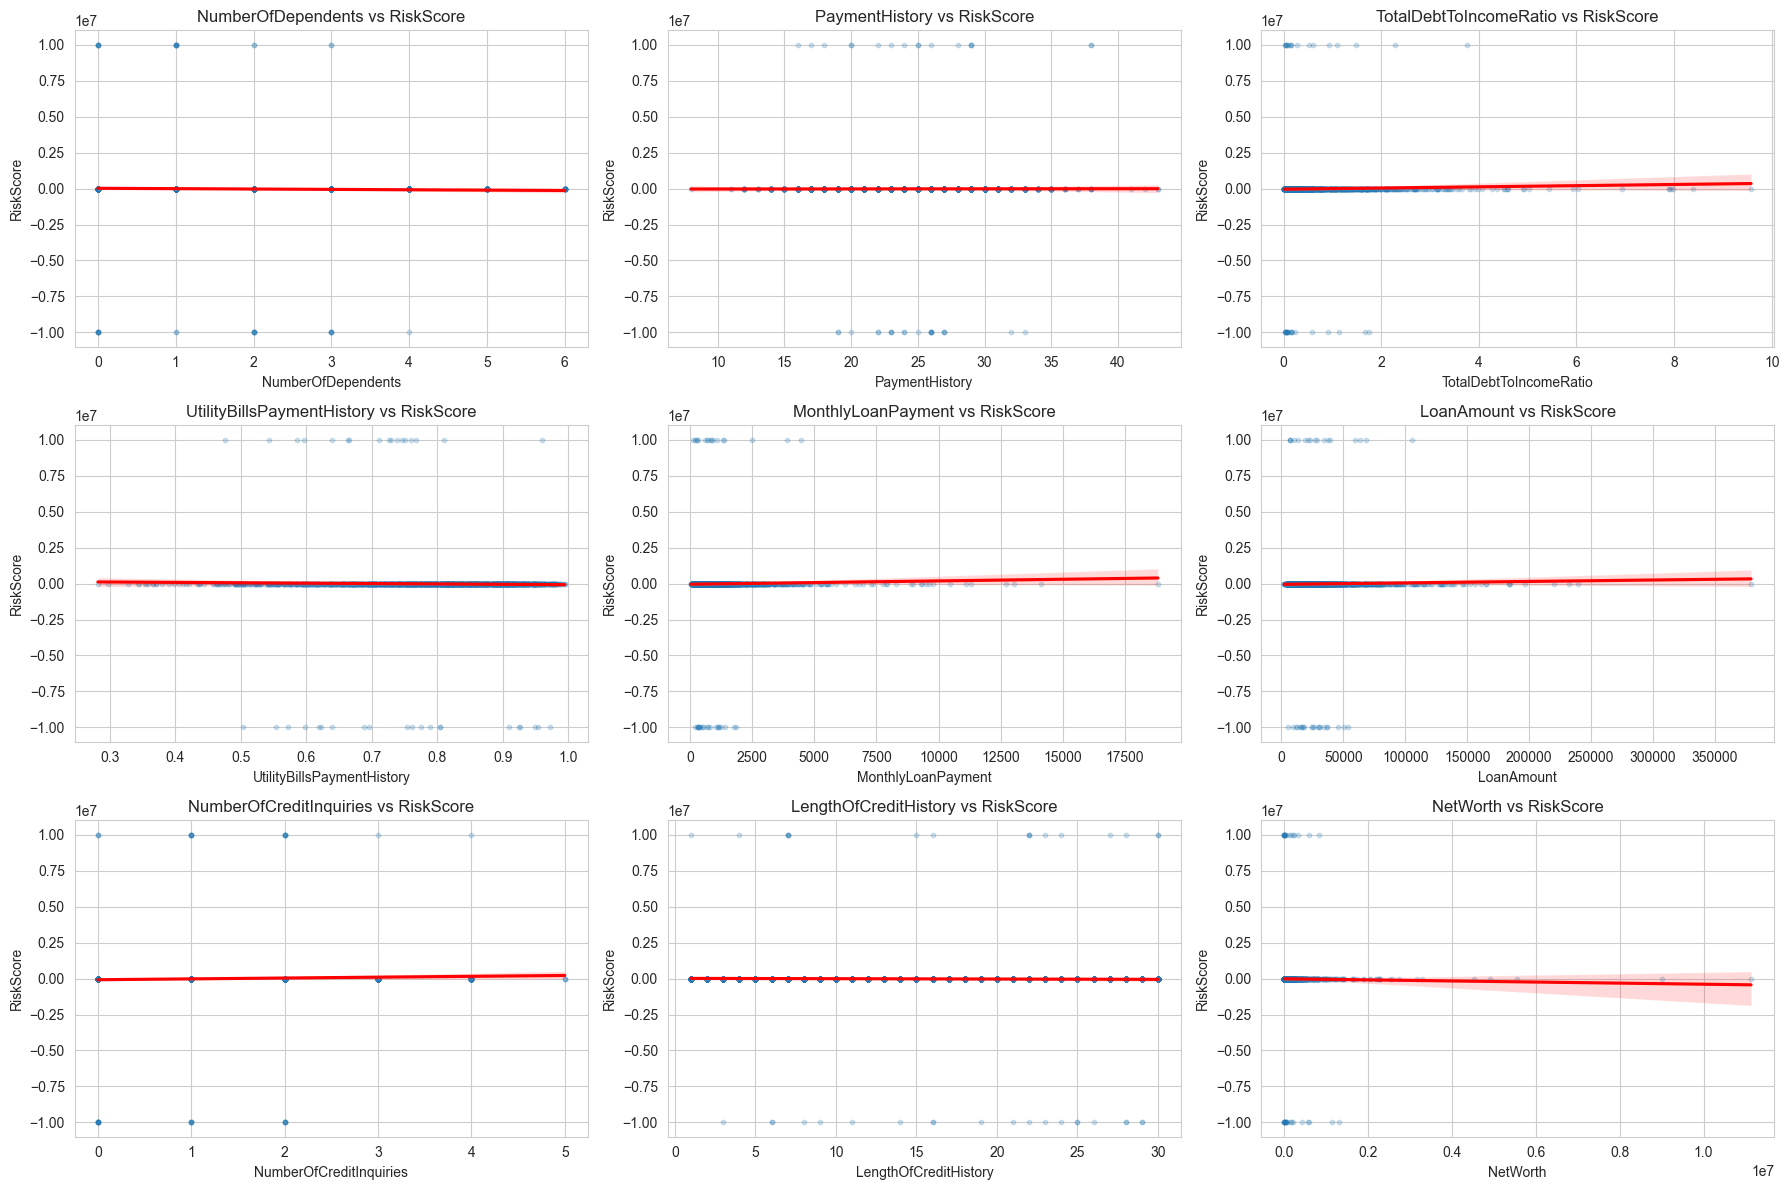

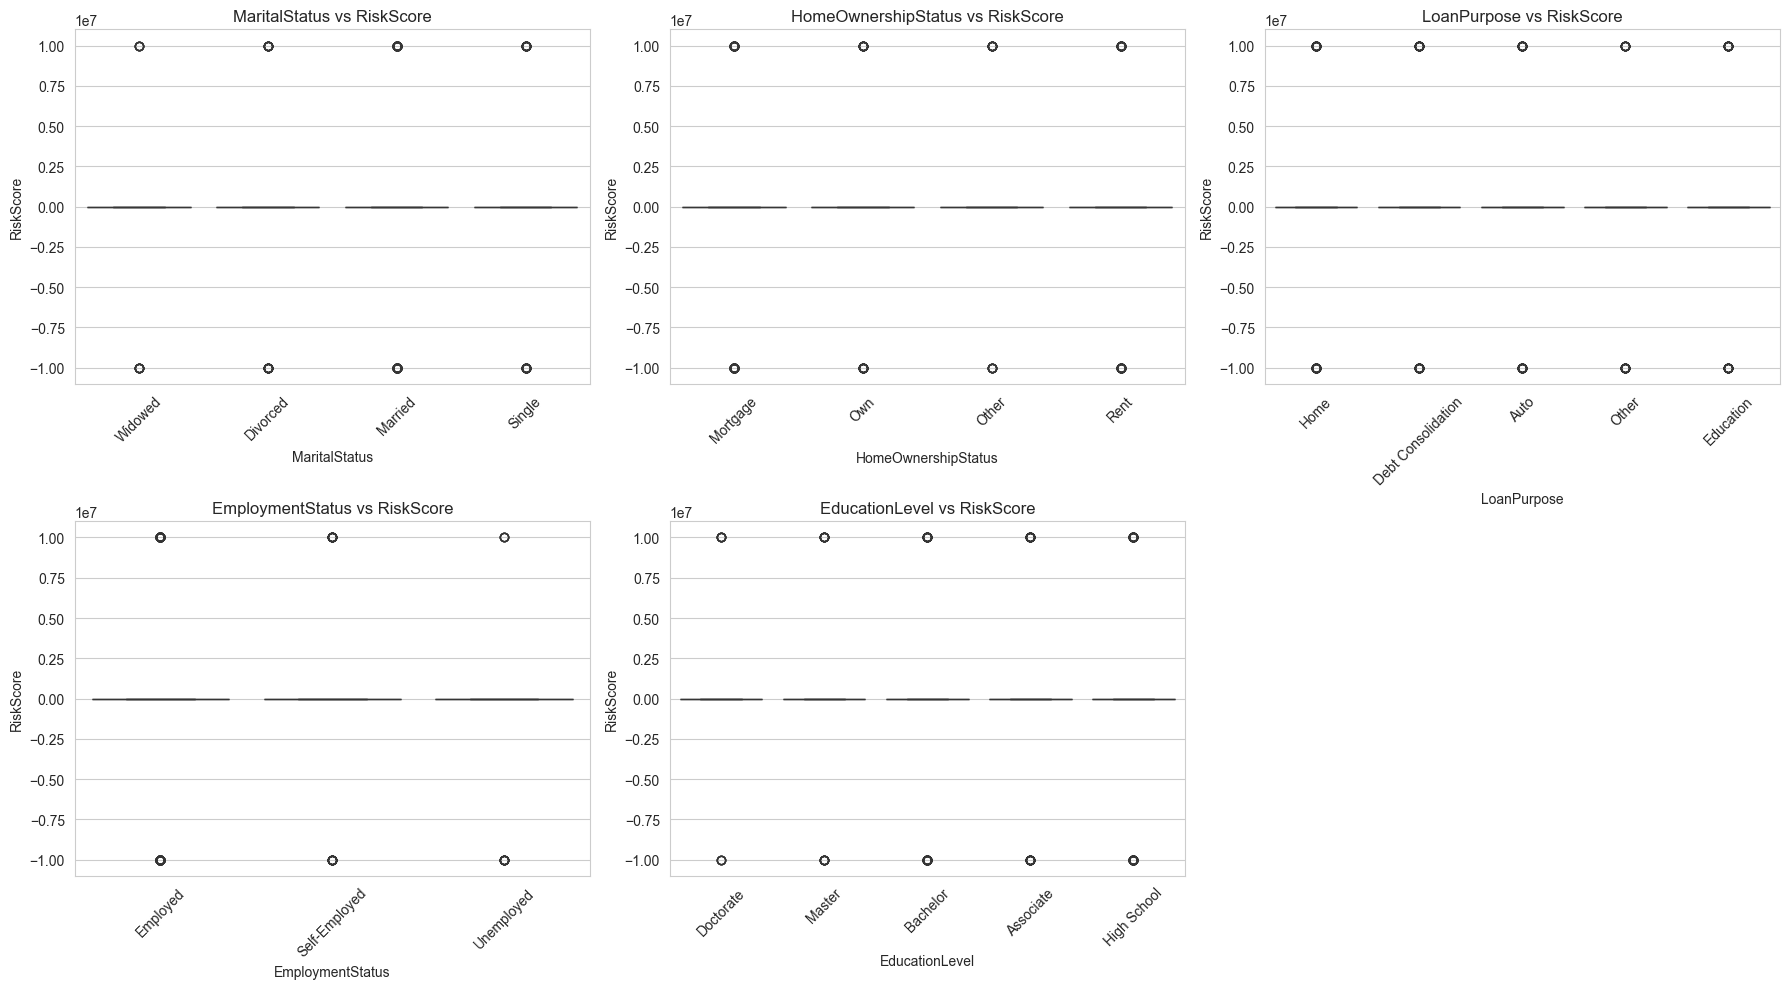


Training...
Признаков создано: 567

 Tuning Alpha (K-Fold=5)...
   Alpha: 0.01   | My CV MSE: 26.4829
   Alpha: 0.1    | My CV MSE: 26.2398
   Alpha: 1.0    | My CV MSE: 26.1021
   Alpha: 5.0    | My CV MSE: 26.3645
   Alpha: 10.0   | My CV MSE: 26.1894
   Alpha: 50.0   | My CV MSE: 27.6228
Best Alpha: 1.0
Обучение финальной модели
submission.csv сохранен

Metrics Compare
1. Scaler Check (Max Diff): 0.0000000000

2. Model Comparison (Analytical vs Sklearn.Ridge):
   My MSE:      20.057330
   Sklearn MSE: 20.057330
   Diff preds:  0.000000

3. Metrics Check (My vs Sklearn):
   MSE:  My=20.05733, Sk=20.05733
   MAE:  My=3.35394, Sk=3.35394
   R2:   My=0.93283, Sk=0.93283
   MAPE: My=0.07764, Sk=0.07764

4. Gradient Descent Check (on 200 samples):
   GD MSE:  2172.5733
   SGD MSE: 1561.5447


In [71]:
def main():
    train_orig = pd.read_csv(TRAIN_PATH)
    test_orig = pd.read_csv(TEST_PATH)


    perform_detailed_eda(train_orig)
    
    print("\n" + "="*50)
    print("Training...")
    print("="*50)
    
    X_train, y_train, X_test = process_and_encode_main(train_orig, test_orig)
    print(f"Признаков создано: {X_train.shape[1]}")
    
    scaler = MyStandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\n Tuning Alpha (K-Fold=5)...")
    alphas = [0.01, 0.1, 1.0, 5.0, 10.0, 50.0]
    best_mse = float('inf')
    best_alpha = 1.0
    
    for alpha in alphas:
        score = my_kfold_cv(MyLinearRegression, X_train_scaled, y_train, k=5, method='analytical', alpha=alpha)
        print(f"   Alpha: {alpha:<6} | My CV MSE: {score:.4f}")
        if score < best_mse:
            best_mse = score
            best_alpha = alpha
            
    print(f"Best Alpha: {best_alpha}")

    print("Обучение финальной модели")
    final_model = MyLinearRegression(method='analytical', alpha=best_alpha)
    final_model.fit(X_train_scaled, y_train)
    
    submission = pd.DataFrame({
        'ID': test_orig['ID'] if 'ID' in test_orig.columns else range(len(X_test)),
        'RiskScore': np.clip(final_model.predict(X_test_scaled), 0, 100)
    })
    submission.to_csv('submission.csv', index=False)
    print("submission.csv сохранен")

    print("\n" + "="*60)
    print("Metrics Compare")
    print("="*60)
    
    sk_sc = SkStandardScaler().fit_transform(X_train)
    diff = np.max(np.abs(X_train_scaled - sk_sc))
    print(f"1. Scaler Check (Max Diff): {diff:.10f}")
    
    idx = np.random.choice(len(X_train_scaled), 2000, replace=False)
    X_sub, y_sub = X_train_scaled[idx], y_train[idx]
    
    my_model = MyLinearRegression(method='analytical', alpha=1.0)
    my_model.fit(X_sub, y_sub)
    my_preds = my_model.predict(X_sub)
    
    sk_model = SkRidge(alpha=1.0, solver='cholesky') 
    sk_model.fit(X_sub, y_sub)
    sk_preds = sk_model.predict(X_sub)
    
    print("\n2. Model Comparison (Analytical vs Sklearn.Ridge):")
    print(f"   My MSE:      {my_mse(y_sub, my_preds):.6f}")
    print(f"   Sklearn MSE: {mean_squared_error(y_sub, sk_preds):.6f}")
    print(f"   Diff preds:  {np.max(np.abs(my_preds - sk_preds)):.6f}")

    print("\n3. Metrics Check (My vs Sklearn):")
    print(f"   MSE:  My={my_mse(y_sub, my_preds):.5f}, Sk={mean_squared_error(y_sub, my_preds):.5f}")
    print(f"   MAE:  My={my_mae(y_sub, my_preds):.5f}, Sk={mean_absolute_error(y_sub, my_preds):.5f}")
    print(f"   R2:   My={my_r2(y_sub, my_preds):.5f}, Sk={r2_score(y_sub, my_preds):.5f}")
    print(f"   MAPE: My={my_mape(y_sub, my_preds):.5f}, Sk={mean_absolute_percentage_error(y_sub, my_preds):.5f}")

    print("\n4. Gradient Descent Check (on 200 samples):")
    X_tiny, y_tiny = X_sub[:200], y_sub[:200]
    
    gd = MyLinearRegression(method='gd', lr=1e-5, epochs=1000, alpha=1.0)
    gd.fit(X_tiny, y_tiny)
    print(f"   GD MSE:  {my_mse(y_tiny, gd.predict(X_tiny)):.4f}")
    
    sgd = MyLinearRegression(method='sgd', lr=1e-4, epochs=100, alpha=1.0)
    sgd.fit(X_tiny, y_tiny)
    print(f"   SGD MSE: {my_mse(y_tiny, sgd.predict(X_tiny)):.4f}")

if __name__ == "__main__":
    main()